In [ ]:

ESTE DOCUMENTO ES PARA RECOGER DATOS ORIGINALES DE FUEGOS Y CREAR UN DATASET DE TRABAJO CON:


A partir de la seleccion hecha des de QGIS sobre el documento .gdb que nos porporciona Tecnosylva con informaciones diversas sobre todos los incendios sucedidos en california desde 1850, se crea el documento "fuegosPost1999/provaSHP1999.shp" con información  de todos los fuegos entre Enero de 2000 y Diciembre 2019     
    
FECHA DE INICIO
ACRES QUEMADOS
LAS COORDENADAS DE UN CUADRADO QUE INCLUYA TODO EL FUEGO (PARA PODER BUSCAR LOS PUNTOS DE IGNICION EN EL HISTORICO CUANDO LOS FUEGOS SON > 3KM DE BANDA) EN WGS84(EPSG:4326))
EL CENTROIDE DE CADA FUEGO EN WGS84(EPSG:4326)) LONG Y LAT 
EL CENTROIDE DE CADA PUNTO ELEGIDO AL AZAR (recogido en el documento noFuegosGDF/noFuegosGDF.shp ) EN WGS84(EPSG:4326)) LONG Y LAT 
TODA LA GEOMETRIA DEL FUEGO EN WGS84(EPSG:4326))


transfarDeDA83aWGS84(x,y)
CONVIERTE UN PUNTO (con coordenadas x, y en NAD83(EPSG:3310) a una proyección WGS84(EPSG:4326)) 

mostrarMapaDeTrabajo(df,corte=300)
A partir de los datos limpios genera un mapa que muestra los centroides de los fuegos menores de X y las areas de los cuadrados de los fuegos mayores de X




In [1]:
import rasterio
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from pyproj import Proj, transform
import numpy as np
import matplotlib.pyplot as plt


import pandas as pd
import geopandas as gpd
import numpy as np

import datetime
from datetime import date
import timeit

from shapely.geometry import Point,Polygon,MultiPolygon
from shapely.ops import cascaded_union
from pyproj import Proj, transform


#from dateutil.relativedelta import relativedelta



%matplotlib inline

## A partir de la seleccion hecha des de QGIS sobre el documento .gdb importo todos los fuegos entre Enero de 2000 y Diciembre 2019

In [2]:
fire1999plus = gpd.read_file("fuegosPost1999/provaSHP1999.shp")
fire1999plus.head()


,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,COMMENTS,REPORT_AC,GIS_ACRES,C_METHOD,OBJECTIVE,FIRE_NUM,Shape_Leng,Shape_Area,geometry
0,1.0,2007,CA,CCO,LAC,OCTOBER,00246393,2007/10/21 00:00:00.000,2007/10/23 00:00:00.000,14.0,None,NaN,25.736713,8.0,1.0,00233414,1902.439051,1.041528e+05,"POLYGON ((138036.906 -402646.363, 138086.986 -..."
1,2.0,2007,CA,CCO,LAC,MAGIC,00233077,2007/10/22 00:00:00.000,2007/10/25 00:00:00.000,14.0,None,NaN,2824.877197,8.0,1.0,00233077,20407.965662,1.143187e+07,"POLYGON ((130072.487 -398622.842, 130094.237 -..."
2,3.0,2007,CA,USF,ANF,RANCH,00000166,2007/10/20 00:00:00.000,2007/11/15 00:00:00.000,2.0,None,54716.0,58410.335938,7.0,1.0,00000166,169150.715690,2.363782e+08,"POLYGON ((114013.974 -379231.746, 114190.835 -..."
3,4.0,2007,CA,CCO,LAC,EMMA,00201384,2007/09/11 00:00:00.000,2007/09/11 00:00:00.000,14.0,None,NaN,172.214951,8.0,1.0,00201384,6117.777086,6.969292e+05,"POLYGON ((176902.236 -388673.082, 176907.996 -..."
4,5.0,2007,CA,CCO,LAC,CORRAL,00259483,2007/11/24 00:00:00.000,2007/11/27 00:00:00.000,14.0,None,NaN,4707.997070,8.0,1.0,00259483,22907.182174,1.905259e+07,"POLYGON ((115905.006 -436381.137, 115926.897 -..."


hay en total: 6336 fuegos


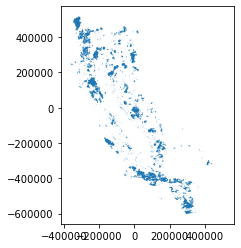

In [3]:
fire1999plus.plot()

print("hay en total: "+ str(len(fire1999plus))+" fuegos")

In [4]:
fire1999plus.crs

{'proj': 'aea',
 'lat_1': 34,
 'lat_2': 40.5,
 'lat_0': 0,
 'lon_0': -120,
 'x_0': 0,
 'y_0': -4000000,
 'datum': 'NAD83',
 'units': 'm',
 'no_defs': True}

BUSCANDO EN GOOGLE:   'proj': 'aea','lat_1': 34,'lat_2': 40.5,


https://spatialreference.org/ref/epsg/3310/proj4/
+proj=aea +lat_1=34 +lat_2=40.5 +lat_0=0 +lon_0=-120 +x_0=0 +y_0=-4000000 +ellps=GRS80 +datum=NAD83 +units=m +no_defs

EPSG:3310: NAD83 / California Albers

https://spatialreference.org/ref/epsg/3310/

EPSG:3310

NAD83 / California Albers (Google it)

    WGS84 Bounds: -124.4200, 32.5100, -114.1300, 42.0000
    Projected Bounds: -415888.0930, -601592.7037, 552169.1580, 457509.0195
    Scope: Natural Resources mapping of whole State.
    Last Revised: Sept. 19, 2005
    Area: USA - California


# ESTOS DATOS ESTAN EN NAD83!     hay que pasarlos a WGS84 si queremos localizar sus coordenadas en otros mapas.

In [5]:
#una vez sabemos que ESTA proyeccion NAD83 en metros corresponde con EPSG:3310 creamos una funcion para transformar los datos a WGS84 in degrees


def transfarDeDA83aWGS84(x,y):
    inProj  = Proj("+init=EPSG:3310",preserve_units=True)
    outProj = Proj("+init=EPSG:4326") # WGS84 en grados corresponde a EPSG:4326
    return transform(inProj,outProj,x,y)

#comprobamos que funciona con los bordes de NAD83
print(f"deberia dar -124.4200, 32.5100")
transfarDeDA83aWGS84( -415888.0930, -601592.7037) 

deberia dar -124.4200, 32.5100


(-124.41999999965998, 32.5099999999369)

# limpiamos los datos.
 para borrar el minimo valores. 
     - reducimos primero el numero de columnas 
     - seguidamente borramos los nan
     - detectamos y corregimos en lo posible valores obiamente anomalos. 

 se puede mejorar suponiendo la fecha de inicio a partir de la fecha de extincion cuando la primera no esta, aunque esto solo sucede en 6 casos

In [6]:
#len(firePost1999[firePost1999.ALARM_DATE.isna()]) #51
firePost1999= fire1999plus.drop(['YEAR_','OBJECTID', 'STATE', 'AGENCY', 'CONT_DATE','CAUSE', 'UNIT_ID' ,'FIRE_NAME' ,'INC_NUM','COMMENTS', 'C_METHOD', 'OBJECTIVE', 'REPORT_AC','FIRE_NUM', 'Shape_Leng', 'Shape_Area'], axis=1)
firePost1999=firePost1999.dropna()

firePost1999

,ALARM_DATE,GIS_ACRES,geometry
0,2007/10/21 00:00:00.000,25.736713,"POLYGON ((138036.906 -402646.363, 138086.986 -..."
1,2007/10/22 00:00:00.000,2824.877197,"POLYGON ((130072.487 -398622.842, 130094.237 -..."
2,2007/10/20 00:00:00.000,58410.335938,"POLYGON ((114013.974 -379231.746, 114190.835 -..."
3,2007/09/11 00:00:00.000,172.214951,"POLYGON ((176902.236 -388673.082, 176907.996 -..."
4,2007/11/24 00:00:00.000,4707.997070,"POLYGON ((115905.006 -436381.137, 115926.897 -..."
...,...,...,...
6330,2019/10/21 00:00:00.000,42.282562,"POLYGON ((133621.354 -438205.997, 133621.094 -..."
6331,2019/10/30 00:00:00.000,6.297734,"POLYGON ((122180.088 -428557.696, 122181.545 -..."
6332,2019/10/28 00:00:00.000,8.482671,"POLYGON ((120221.043 -428836.863, 120220.166 -..."
6333,2019/11/09 00:00:00.000,64.888229,"POLYGON ((153212.742 -428811.823, 153216.210 -..."


In [7]:
fuegosOrdenadosXt = firePost1999.sort_values(by=['ALARM_DATE'] , ascending=False,ignore_index=True)
fuegosOrdenadosXt

,ALARM_DATE,GIS_ACRES,geometry
0,2106/09/26 00:00:00.000,930.506470,"POLYGON ((-24253.448 -27481.751, -24309.173 -2..."
1,2019/12/19 00:00:00.000,12.634579,"POLYGON ((-10551.228 -27844.203, -10548.820 -2..."
2,2019/11/25 00:00:00.000,3125.905518,"MULTIPOLYGON (((18960.430 -391658.392, 18956.3..."
3,2019/11/25 00:00:00.000,24.590448,"POLYGON ((-114608.774 92263.611, -114623.297 9..."
4,2019/11/21 00:00:00.000,73.552673,"POLYGON ((-80262.329 225563.780, -80260.657 22..."
...,...,...,...
6274,2000/01/05 00:00:00.000,8.172387,"POLYGON ((-48411.437 -384007.662, -48409.447 -..."
6275,2000/01/04 00:00:00.000,41.443298,"POLYGON ((-9945.240 311.120, -9994.780 278.670..."
6276,2000/01/01 00:00:00.000,4.834736,"POLYGON ((112920.614 -173590.564, 112892.814 -..."
6277,0219/05/29 00:00:00.000,2.296940,"POLYGON ((213452.071 -468768.278, 213452.494 -..."


# vemos que hay fechas imposibles las corregimos manualmente

In [8]:
fuegosOrdenadosXt['ALARM_DATE'] = fuegosOrdenadosXt['ALARM_DATE'].replace(['2106/09/26 00:00:00.000'],'2016/09/26 00:00:00.000')
fuegosOrdenadosXt['ALARM_DATE'] = fuegosOrdenadosXt['ALARM_DATE'].replace(['0219/05/29 00:00:00.000'],'2019/05/29 00:00:00.000')
fuegosOrdenadosXt['ALARM_DATE'] = fuegosOrdenadosXt['ALARM_DATE'].replace(['0208/11/13 00:00:00.000'],'2008/11/13 00:00:00.000')

fuegosOrdenadosXt = fuegosOrdenadosXt.sort_values(by=['ALARM_DATE'] , ascending=True,ignore_index=True)
fuegosOrdenadosXt

,ALARM_DATE,GIS_ACRES,geometry
0,2000/01/01 00:00:00.000,4.834736,"POLYGON ((112920.614 -173590.564, 112892.814 -..."
1,2000/01/04 00:00:00.000,41.443298,"POLYGON ((-9945.240 311.120, -9994.780 278.670..."
2,2000/01/05 00:00:00.000,8.172387,"POLYGON ((-48411.437 -384007.662, -48409.447 -..."
3,2000/02/25 00:00:00.000,171.886719,"POLYGON ((154724.105 -392690.642, 154727.775 -..."
4,2000/03/25 00:00:00.000,1358.237549,"MULTIPOLYGON (((-246428.582 161994.989, -24642..."
...,...,...,...
6274,2019/11/19 00:00:00.000,7.903546,"POLYGON ((-12860.145 8874.868, -12865.393 8879..."
6275,2019/11/21 00:00:00.000,73.552673,"POLYGON ((-80262.329 225563.780, -80260.657 22..."
6276,2019/11/25 00:00:00.000,24.590448,"POLYGON ((-114608.774 92263.611, -114623.297 9..."
6277,2019/11/25 00:00:00.000,3125.905518,"MULTIPOLYGON (((18960.430 -391658.392, 18956.3..."


# SEPARAMOS LA FECHA DE ALARMA PARA FACILITAR SU ACCESO

In [9]:
# modificamos el tipo de fecha para poder buscar mejor
listaDeFechas=[]

for fuego in range(len(fuegosOrdenadosXt)):
    fecha=datetime.date(int(fuegosOrdenadosXt.ALARM_DATE[fuego][0:4]),int(fuegosOrdenadosXt.ALARM_DATE[fuego][5:7]),int(fuegosOrdenadosXt.ALARM_DATE[fuego][8:10]))
    listaDeFechas.append(fecha)
    
fuegosOrdenadosXt['ALARM_DATE']=listaDeFechas
fuegosOrdenadosXt

,ALARM_DATE,GIS_ACRES,geometry
0,2000-01-01,4.834736,"POLYGON ((112920.614 -173590.564, 112892.814 -..."
1,2000-01-04,41.443298,"POLYGON ((-9945.240 311.120, -9994.780 278.670..."
2,2000-01-05,8.172387,"POLYGON ((-48411.437 -384007.662, -48409.447 -..."
3,2000-02-25,171.886719,"POLYGON ((154724.105 -392690.642, 154727.775 -..."
4,2000-03-25,1358.237549,"MULTIPOLYGON (((-246428.582 161994.989, -24642..."
...,...,...,...
6274,2019-11-19,7.903546,"POLYGON ((-12860.145 8874.868, -12865.393 8879..."
6275,2019-11-21,73.552673,"POLYGON ((-80262.329 225563.780, -80260.657 22..."
6276,2019-11-25,24.590448,"POLYGON ((-114608.774 92263.611, -114623.297 9..."
6277,2019-11-25,3125.905518,"MULTIPOLYGON (((18960.430 -391658.392, 18956.3..."


In [10]:
geo_df=fuegosOrdenadosXt.sort_values(by=['ALARM_DATE'], ascending=True,ignore_index=True)
geo_df

,ALARM_DATE,GIS_ACRES,geometry
0,2000-01-01,4.834736,"POLYGON ((112920.614 -173590.564, 112892.814 -..."
1,2000-01-04,41.443298,"POLYGON ((-9945.240 311.120, -9994.780 278.670..."
2,2000-01-05,8.172387,"POLYGON ((-48411.437 -384007.662, -48409.447 -..."
3,2000-02-25,171.886719,"POLYGON ((154724.105 -392690.642, 154727.775 -..."
4,2000-03-25,1358.237549,"MULTIPOLYGON (((-246428.582 161994.989, -24642..."
...,...,...,...
6274,2019-11-19,7.903546,"POLYGON ((-12860.145 8874.868, -12865.393 8879..."
6275,2019-11-21,73.552673,"POLYGON ((-80262.329 225563.780, -80260.657 22..."
6276,2019-11-25,3125.905518,"MULTIPOLYGON (((18960.430 -391658.392, 18956.3..."
6277,2019-11-25,24.590448,"POLYGON ((-114608.774 92263.611, -114623.297 9..."


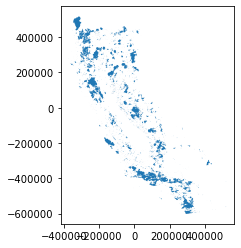

In [11]:
geo_df.plot()

# CREAMOS MARCOS GEOGRAFICOS DE LOS FUEGOS PARA PODER BUSCAR EL ORIGEN DE LOS GRANDES FUEGOS  CON EL HISTORICO DE TEMPERATURA DE LOS SATELITES 

# para los fuegos mayores tendremos que buscar los puntos calientes en el momento de la ignicion en el area de ignicion. 

Para no tener que cargar toda la informacion del dia de toda california recogemos las coordenadas del rectangulo de referencia en el que se encuentra el fuego.

estos datos necesitaran ser pasados a wgs84 para poder encontrar la informacion

In [12]:
x1_=[]
x2_=[]
y1_=[]
y2_=[]

for shape in range(len(geo_df["geometry"])):
    x1,y1,x2,y2=geo_df["geometry"][shape].bounds
    x1_.append(x1)
    x2_.append(x2)
    y1_.append(y1)
    y2_.append(y2)
                   
geo_df["x1"] = x1_
geo_df["x2"] = x2_
geo_df["y1"] = y1_
geo_df["y2"] = y2_
            
geo_df

,ALARM_DATE,GIS_ACRES,geometry,x1,x2,y1,y2
0,2000-01-01,4.834736,"POLYGON ((112920.614 -173590.564, 112892.814 -...",112892.8142,113023.8630,-173590.5640,-173378.1036
1,2000-01-04,41.443298,"POLYGON ((-9945.240 311.120, -9994.780 278.670...",-10033.9098,-9388.3502,278.6702,723.2401
2,2000-01-05,8.172387,"POLYGON ((-48411.437 -384007.662, -48409.447 -...",-48600.0011,-48366.3468,-384274.9932,-383975.6210
3,2000-02-25,171.886719,"POLYGON ((154724.105 -392690.642, 154727.775 -...",154547.4429,155715.7495,-393749.3719,-392664.5922
4,2000-03-25,1358.237549,"MULTIPOLYGON (((-246428.582 161994.989, -24642...",-246926.2956,-243785.0741,161448.9331,165705.9810
...,...,...,...,...,...,...,...
6274,2019-11-19,7.903546,"POLYGON ((-12860.145 8874.868, -12865.393 8879...",-13098.3644,-12845.2400,8743.8772,9015.0961
6275,2019-11-21,73.552673,"POLYGON ((-80262.329 225563.780, -80260.657 22...",-80262.3292,-79590.8751,225427.7138,226294.2650
6276,2019-11-25,3125.905518,"MULTIPOLYGON (((18960.430 -391658.392, 18956.3...",18894.5830,23409.7679,-395368.3879,-389359.3391
6277,2019-11-25,24.590448,"POLYGON ((-114608.774 92263.611, -114623.297 9...",-114758.3002,-114498.4242,92261.3685,92851.6956


# generamos ahora los centroides de los fuegos que nos serviran de referencia como punto de ignicion de los fuegos de perimetro pequeño

In [13]:
#recogemos tb el enctroide de los fuegos

geo_df["centroideFuego"] = geo_df.centroid
geo_df

,ALARM_DATE,GIS_ACRES,geometry,x1,x2,y1,y2,centroideFuego
0,2000-01-01,4.834736,"POLYGON ((112920.614 -173590.564, 112892.814 -...",112892.8142,113023.8630,-173590.5640,-173378.1036,POINT (112964.695 -173485.557)
1,2000-01-04,41.443298,"POLYGON ((-9945.240 311.120, -9994.780 278.670...",-10033.9098,-9388.3502,278.6702,723.2401,POINT (-9715.211 535.255)
2,2000-01-05,8.172387,"POLYGON ((-48411.437 -384007.662, -48409.447 -...",-48600.0011,-48366.3468,-384274.9932,-383975.6210,POINT (-48474.011 -384113.298)
3,2000-02-25,171.886719,"POLYGON ((154724.105 -392690.642, 154727.775 -...",154547.4429,155715.7495,-393749.3719,-392664.5922,POINT (155138.257 -393148.366)
4,2000-03-25,1358.237549,"MULTIPOLYGON (((-246428.582 161994.989, -24642...",-246926.2956,-243785.0741,161448.9331,165705.9810,POINT (-245156.936 163623.181)
...,...,...,...,...,...,...,...,...
6274,2019-11-19,7.903546,"POLYGON ((-12860.145 8874.868, -12865.393 8879...",-13098.3644,-12845.2400,8743.8772,9015.0961,POINT (-12971.449 8883.205)
6275,2019-11-21,73.552673,"POLYGON ((-80262.329 225563.780, -80260.657 22...",-80262.3292,-79590.8751,225427.7138,226294.2650,POINT (-79847.833 225826.031)
6276,2019-11-25,3125.905518,"MULTIPOLYGON (((18960.430 -391658.392, 18956.3...",18894.5830,23409.7679,-395368.3879,-389359.3391,POINT (21500.568 -392100.378)
6277,2019-11-25,24.590448,"POLYGON ((-114608.774 92263.611, -114623.297 9...",-114758.3002,-114498.4242,92261.3685,92851.6956,POINT (-114637.932 92524.413)


In [14]:
from shapely.geometry import Point,Polygon,MultiPolygon

# creacion de poligonos
def poligonoRecorte(df,n):
    lo1=(df["x1"][n])
    lo2=(df["x2"][n])
    la1=(df["y1"][n])
    la2=(df["y2"][n])
    return Polygon([(lo1, la1), (lo1, la2),(lo2, la2), (lo2, la1)])


poligons=[]

for shape in range(len(geo_df)):
    lo1,la1,lo2,la2=geo_df["geometry"][shape].bounds
    poligons.append(Polygon([(lo1, la1), (lo1, la2),(lo2, la2), (lo2, la1)]))
                   
geo_df["fireRectangle"] = poligons
geo_df

,ALARM_DATE,GIS_ACRES,geometry,x1,x2,y1,y2,centroideFuego,fireRectangle
0,2000-01-01,4.834736,"POLYGON ((112920.614 -173590.564, 112892.814 -...",112892.8142,113023.8630,-173590.5640,-173378.1036,POINT (112964.695 -173485.557),"POLYGON ((112892.814199999 -173590.5639999993,..."
1,2000-01-04,41.443298,"POLYGON ((-9945.240 311.120, -9994.780 278.670...",-10033.9098,-9388.3502,278.6702,723.2401,POINT (-9715.211 535.255),POLYGON ((-10033.90980000049 278.6701999995857...
2,2000-01-05,8.172387,"POLYGON ((-48411.437 -384007.662, -48409.447 -...",-48600.0011,-48366.3468,-384274.9932,-383975.6210,POINT (-48474.011 -384113.298),POLYGON ((-48600.00109999999 -384274.993200000...
3,2000-02-25,171.886719,"POLYGON ((154724.105 -392690.642, 154727.775 -...",154547.4429,155715.7495,-393749.3719,-392664.5922,POINT (155138.257 -393148.366),POLYGON ((154547.4428999983 -393749.3718999997...
4,2000-03-25,1358.237549,"MULTIPOLYGON (((-246428.582 161994.989, -24642...",-246926.2956,-243785.0741,161448.9331,165705.9810,POINT (-245156.936 163623.181),"POLYGON ((-246926.2956000008 161448.9331, -246..."
...,...,...,...,...,...,...,...,...,...
6274,2019-11-19,7.903546,"POLYGON ((-12860.145 8874.868, -12865.393 8879...",-13098.3644,-12845.2400,8743.8772,9015.0961,POINT (-12971.449 8883.205),POLYGON ((-13098.36439999938 8743.877199999988...
6275,2019-11-21,73.552673,"POLYGON ((-80262.329 225563.780, -80260.657 22...",-80262.3292,-79590.8751,225427.7138,226294.2650,POINT (-79847.833 225826.031),"POLYGON ((-80262.32919999957 225427.7138, -802..."
6276,2019-11-25,3125.905518,"MULTIPOLYGON (((18960.430 -391658.392, 18956.3...",18894.5830,23409.7679,-395368.3879,-389359.3391,POINT (21500.568 -392100.378),POLYGON ((18894.58300000057 -395368.3879000004...
6277,2019-11-25,24.590448,"POLYGON ((-114608.774 92263.611, -114623.297 9...",-114758.3002,-114498.4242,92261.3685,92851.6956,POINT (-114637.932 92524.413),POLYGON ((-114758.3002000004 92261.36849999987...


In [15]:
totalFuegos= geo_df.loc[geo_df['GIS_ACRES'] < 1235]
len(totalFuegos)

5480

#De estos 6279 selecciono para los datos finales los que son suficientemente pequeños como para considerarlos puntos de ignicion: 

>60 acres (0.24km2) desde 2000 = 3275 fuegos

>247 acres (1km2) desde 2000 = 4568 fuegos

>741 acres (3km2) desde 2000 = 5260 fuegos

>1235 acres(5km2) desde 2000 = 5480 fuegos

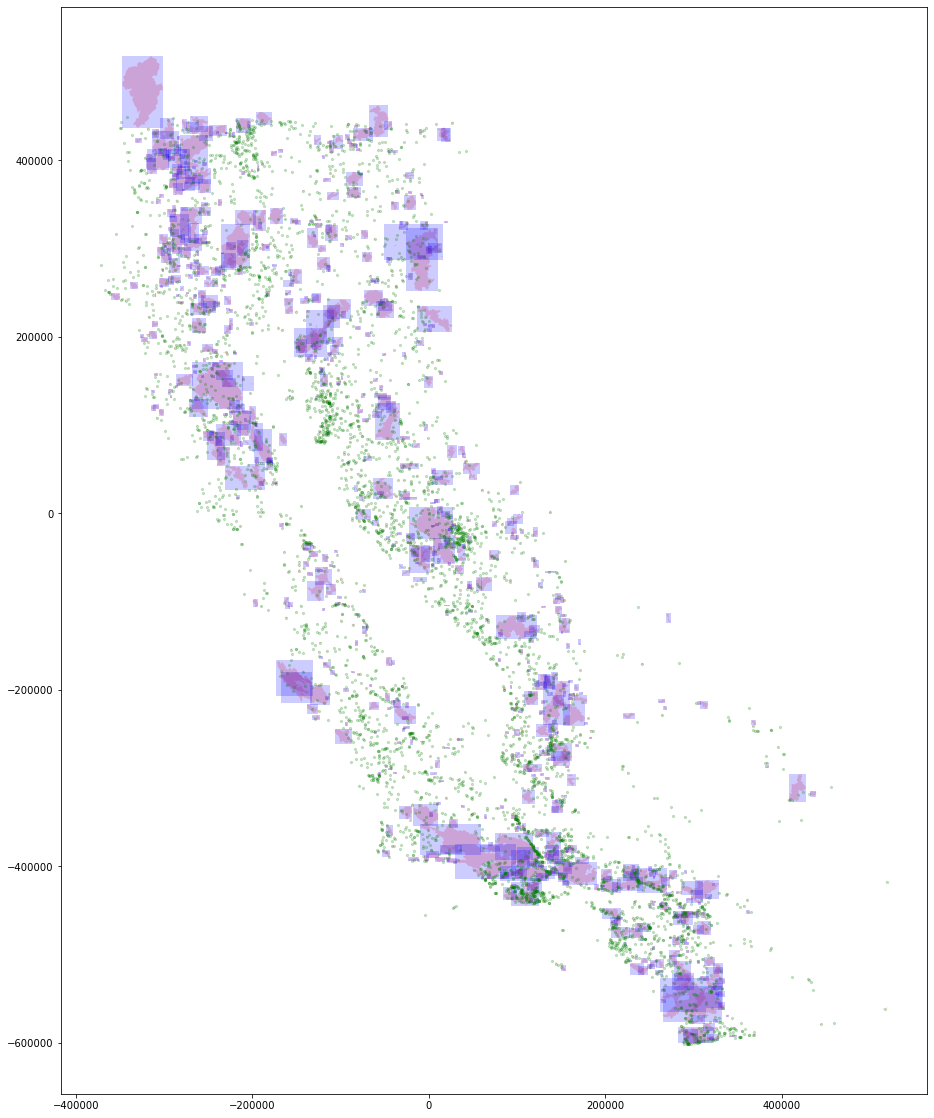

In [16]:
def mostrarMapaDeTrabajo(df,corte=300):

    fig, ax = plt.subplots(figsize=(20, 20))

    #creamos un df con los poligons de los fuegos mayores de X, estos poligonos son la nueva gometry
    perimetro0 = df.loc[df['GIS_ACRES'] > corte]
    perimetro0.reset_index(drop=True, inplace=True)
    perimetro0 = perimetro0.copy()

    perimetro0['geometry'] = perimetro0['fireRectangle']

    #creamos un df con los puntos de ingnicion ya definitivos!
    perimetro1 = df.loc[df['GIS_ACRES'] < corte]
    perimetro1.reset_index(drop=True, inplace=True)
    perimetro1 = perimetro1.copy()

    perimetro1['geometry'] = perimetro1['centroideFuego']

    #Los fuegos ya son el geometry del df original
    df.plot(ax=ax, facecolor='red', alpha=0.2)

    perimetro0.plot(ax=ax, facecolor='blue', alpha=0.2);

    perimetro1.plot(ax=ax, facecolor='green', markersize=5, alpha=0.2);

mostrarMapaDeTrabajo(geo_df,corte=1235)

# Ya tenemos toda la información que queremos ahora la transportamos al sistema GPS utilizando el transformador que hemos generado previamente

In [17]:
#una vez sabemos que ESTA proyeccion NAD83 en metros corresponde con EPSG:3310 creamos una funcion para transformar los datos a WGS84 in degrees
def transfarDeDA83aWGS84(x,y):
    inProj  = Proj("+init=EPSG:3310",preserve_units=True)
    outProj = Proj("+init=EPSG:4326") # WGS84 en grados corresponde a EPSG:4326
    return transform(inProj,outProj,x,y)


In [18]:
# DEJO LA GEOMETRIA DEL GDF EN 3310 PERO GUARDO TODOS LOS OTROS DATOS EN WGS 84 

long_1=[]
long_2=[]
lat_1=[]
lat_2=[]
WGScentroid=[]
longitudes=[]
latitudes=[]
geometria3310=[]

for shape in range(len(geo_df)):
    long1,lat1=transfarDeDA83aWGS84(geo_df["x1"][shape],geo_df["y1"][shape])
    long2,lat2=transfarDeDA83aWGS84(geo_df["x2"][shape],geo_df["y2"][shape])
    
    long_1.append(long1)
    long_2.append(long2)
    lat_1.append(lat1)
    lat_2.append(lat2)
    
    
    #WGSc = transfarDeDA83aWGS84(geo_df["centroideFuego"][shape].coords[0][0],geo_df["centroideFuego"][shape].coords[0][1])

    longitud,latitud = transfarDeDA83aWGS84(geo_df["centroideFuego"][shape].coords[0][0],geo_df["centroideFuego"][shape].coords[0][1])

    #WGScentroid.append(WGSc)
    longitudes.append(longitud)
    latitudes.append(latitud)
    

    
                   
geo_df["F4_LO_1"] = long_1
geo_df["F4_LO_2"] = long_2

geo_df["F4_LA_1"] = lat_1
geo_df["F4_LA_2"] = lat_2
            
#geo_df["WGScentroidGeometry"] = WGScentroid
geo_df["CenFuegLon"] = longitudes
geo_df["CenFuegLat"] = latitudes





In [19]:
geo_df

,ALARM_DATE,GIS_ACRES,geometry,x1,x2,y1,y2,centroideFuego,fireRectangle,F4_LO_1,F4_LO_2,F4_LA_1,F4_LA_2,CenFuegLon,CenFuegLat
0,2000-01-01,4.834736,"POLYGON ((112920.614 -173590.564, 112892.814 -...",112892.8142,113023.8630,-173590.5640,-173378.1036,POINT (112964.695 -173485.557),"POLYGON ((112892.814199999 -173590.5639999993,...",-118.738840,-118.737344,36.447933,36.449829,-118.738021,36.448869
1,2000-01-04,41.443298,"POLYGON ((-9945.240 311.120, -9994.780 278.670...",-10033.9098,-9388.3502,278.6702,723.2401,POINT (-9715.211 535.255),POLYGON ((-10033.90980000049 278.6701999995857...,-120.114443,-120.107086,38.018818,38.022824,-120.110812,38.021129
2,2000-01-05,8.172387,"POLYGON ((-48411.437 -384007.662, -48409.447 -...",-48600.0011,-48366.3468,-384274.9932,-383975.6210,POINT (-48474.011 -384113.298),POLYGON ((-48600.00109999999 -384274.993200000...,-120.529799,-120.527270,34.556587,34.559296,-120.528435,34.558050
3,2000-02-25,171.886719,"POLYGON ((154724.105 -392690.642, 154727.775 -...",154547.4429,155715.7495,-393749.3719,-392664.5922,POINT (155138.257 -393148.366),POLYGON ((154547.4428999983 -393749.3718999997...,-118.317238,-118.304309,34.460083,34.469669,-118.310690,34.465403
4,2000-03-25,1358.237549,"MULTIPOLYGON (((-246428.582 161994.989, -24642...",-246926.2956,-243785.0741,161448.9331,165705.9810,POINT (-245156.936 163623.181),"POLYGON ((-246926.2956000008 161448.9331, -246...",-122.871162,-122.836140,39.435238,39.474381,-122.851362,39.455276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6274,2019-11-19,7.903546,"POLYGON ((-12860.145 8874.868, -12865.393 8879...",-13098.3644,-12845.2400,8743.8772,9015.0961,POINT (-12971.449 8883.205),POLYGON ((-13098.36439999938 8743.877199999988...,-120.149547,-120.146662,38.094928,38.097372,-120.148101,38.096183
6275,2019-11-21,73.552673,"POLYGON ((-80262.329 225563.780, -80260.657 22...",-80262.3292,-79590.8751,225427.7138,226294.2650,POINT (-79847.833 225826.031),"POLYGON ((-80262.32919999957 225427.7138, -802...",-120.940899,-120.933128,40.041148,40.049008,-120.936086,40.044770
6276,2019-11-25,3125.905518,"MULTIPOLYGON (((18960.430 -391658.392, 18956.3...",18894.5830,23409.7679,-395368.3879,-389359.3391,POINT (21500.568 -392100.378),POLYGON ((18894.58300000057 -395368.3879000004...,-119.794287,-119.744952,34.457668,34.511715,-119.765827,34.487061
6277,2019-11-25,24.590448,"POLYGON ((-114608.774 92263.611, -114623.297 9...",-114758.3002,-114498.4242,92261.3685,92851.6956,POINT (-114637.932 92524.413),POLYGON ((-114758.3002000004 92261.36849999987...,-121.323453,-121.320551,38.839142,38.844485,-121.322107,38.841523


In [20]:
del geo_df['x1']
del geo_df['x2']
del geo_df['y1']
del geo_df['y2']

del geo_df['centroideFuego']
del geo_df['fireRectangle']

#del geo_df['WGScentroidGeometry']
geo_df

,ALARM_DATE,GIS_ACRES,geometry,F4_LO_1,F4_LO_2,F4_LA_1,F4_LA_2,CenFuegLon,CenFuegLat
0,2000-01-01,4.834736,"POLYGON ((112920.614 -173590.564, 112892.814 -...",-118.738840,-118.737344,36.447933,36.449829,-118.738021,36.448869
1,2000-01-04,41.443298,"POLYGON ((-9945.240 311.120, -9994.780 278.670...",-120.114443,-120.107086,38.018818,38.022824,-120.110812,38.021129
2,2000-01-05,8.172387,"POLYGON ((-48411.437 -384007.662, -48409.447 -...",-120.529799,-120.527270,34.556587,34.559296,-120.528435,34.558050
3,2000-02-25,171.886719,"POLYGON ((154724.105 -392690.642, 154727.775 -...",-118.317238,-118.304309,34.460083,34.469669,-118.310690,34.465403
4,2000-03-25,1358.237549,"MULTIPOLYGON (((-246428.582 161994.989, -24642...",-122.871162,-122.836140,39.435238,39.474381,-122.851362,39.455276
...,...,...,...,...,...,...,...,...,...
6274,2019-11-19,7.903546,"POLYGON ((-12860.145 8874.868, -12865.393 8879...",-120.149547,-120.146662,38.094928,38.097372,-120.148101,38.096183
6275,2019-11-21,73.552673,"POLYGON ((-80262.329 225563.780, -80260.657 22...",-120.940899,-120.933128,40.041148,40.049008,-120.936086,40.044770
6276,2019-11-25,3125.905518,"MULTIPOLYGON (((18960.430 -391658.392, 18956.3...",-119.794287,-119.744952,34.457668,34.511715,-119.765827,34.487061
6277,2019-11-25,24.590448,"POLYGON ((-114608.774 92263.611, -114623.297 9...",-121.323453,-121.320551,38.839142,38.844485,-121.322107,38.841523


# Anadimos al GDF el listado de espacions sin fuego elegidos al azar

In [21]:
SinFuego = gpd.read_file("noFuegosGDF/noFuegosGDF.shp")
SinFuego

,ALARM_DATE,GIS_ACRES,noFuegoSLo,noFuegoSLa,geometry
0,2000-01-01,4.834736,-123.185385,40.449521,POINT (-123.18539 40.44952)
1,2000-01-04,41.443298,-120.276723,35.715708,POINT (-120.27672 35.71571)
2,2000-01-05,8.172387,-120.851592,38.090275,POINT (-120.85159 38.09027)
3,2000-02-25,171.886719,-117.728860,35.813797,POINT (-117.72886 35.81380)
4,2000-03-25,1358.237549,-114.680674,34.317121,POINT (-114.68067 34.31712)
...,...,...,...,...,...
6274,2019-11-19,7.903546,-119.864456,35.278568,POINT (-119.86446 35.27857)
6275,2019-11-21,73.552673,-121.702775,36.604210,POINT (-121.70278 36.60421)
6276,2019-11-25,24.590448,-118.073346,37.597320,POINT (-118.07335 37.59732)
6277,2019-11-25,3125.905518,-120.443072,38.305475,POINT (-120.44307 38.30548)


In [22]:
geo_df['sinFuegoLong']=SinFuego['noFuegoSLo']
geo_df['sinFuegoLat']=SinFuego['noFuegoSLa']
geo_df

,ALARM_DATE,GIS_ACRES,geometry,F4_LO_1,F4_LO_2,F4_LA_1,F4_LA_2,CenFuegLon,CenFuegLat,sinFuegoLong,sinFuegoLat
0,2000-01-01,4.834736,"POLYGON ((112920.614 -173590.564, 112892.814 -...",-118.738840,-118.737344,36.447933,36.449829,-118.738021,36.448869,-123.185385,40.449521
1,2000-01-04,41.443298,"POLYGON ((-9945.240 311.120, -9994.780 278.670...",-120.114443,-120.107086,38.018818,38.022824,-120.110812,38.021129,-120.276723,35.715708
2,2000-01-05,8.172387,"POLYGON ((-48411.437 -384007.662, -48409.447 -...",-120.529799,-120.527270,34.556587,34.559296,-120.528435,34.558050,-120.851592,38.090275
3,2000-02-25,171.886719,"POLYGON ((154724.105 -392690.642, 154727.775 -...",-118.317238,-118.304309,34.460083,34.469669,-118.310690,34.465403,-117.728860,35.813797
4,2000-03-25,1358.237549,"MULTIPOLYGON (((-246428.582 161994.989, -24642...",-122.871162,-122.836140,39.435238,39.474381,-122.851362,39.455276,-114.680674,34.317121
...,...,...,...,...,...,...,...,...,...,...,...
6274,2019-11-19,7.903546,"POLYGON ((-12860.145 8874.868, -12865.393 8879...",-120.149547,-120.146662,38.094928,38.097372,-120.148101,38.096183,-119.864456,35.278568
6275,2019-11-21,73.552673,"POLYGON ((-80262.329 225563.780, -80260.657 22...",-120.940899,-120.933128,40.041148,40.049008,-120.936086,40.044770,-121.702775,36.604210
6276,2019-11-25,3125.905518,"MULTIPOLYGON (((18960.430 -391658.392, 18956.3...",-119.794287,-119.744952,34.457668,34.511715,-119.765827,34.487061,-118.073346,37.597320
6277,2019-11-25,24.590448,"POLYGON ((-114608.774 92263.611, -114623.297 9...",-121.323453,-121.320551,38.839142,38.844485,-121.322107,38.841523,-120.443072,38.305475


In [23]:
Guardamos este documento en el que los geodatos son los poligonos

#primero convertimos las fechas en str
geo_df["ALARM_DATE"] = geo_df["ALARM_DATE"].astype(str) 
#tb hemos creado una carpeta donde esta python para ordenar los shapefiles
geo_df.to_file("datosLimpiosTotalOct14/datosLimpiosTotalOct14.shp")


In [34]:
#Guardamos una version csv poco pesada sin geodatos

FuegosRectanguloYNoFuegos = geo_df.copy()

In [35]:


del FuegosRectanguloYNoFuegos['geometry']
FuegosRectanguloYNoFuegos

,ALARM_DATE,GIS_ACRES,F4_LO_1,F4_LO_2,F4_LA_1,F4_LA_2,CenFuegLon,CenFuegLat,sinFuegoLong,sinFuegoLat
0,2000-01-01,4.834736,-118.738840,-118.737344,36.447933,36.449829,-118.738021,36.448869,-123.185385,40.449521
1,2000-01-04,41.443298,-120.114443,-120.107086,38.018818,38.022824,-120.110812,38.021129,-120.276723,35.715708
2,2000-01-05,8.172387,-120.529799,-120.527270,34.556587,34.559296,-120.528435,34.558050,-120.851592,38.090275
3,2000-02-25,171.886719,-118.317238,-118.304309,34.460083,34.469669,-118.310690,34.465403,-117.728860,35.813797
4,2000-03-25,1358.237549,-122.871162,-122.836140,39.435238,39.474381,-122.851362,39.455276,-114.680674,34.317121
...,...,...,...,...,...,...,...,...,...,...
6274,2019-11-19,7.903546,-120.149547,-120.146662,38.094928,38.097372,-120.148101,38.096183,-119.864456,35.278568
6275,2019-11-21,73.552673,-120.940899,-120.933128,40.041148,40.049008,-120.936086,40.044770,-121.702775,36.604210
6276,2019-11-25,3125.905518,-119.794287,-119.744952,34.457668,34.511715,-119.765827,34.487061,-118.073346,37.597320
6277,2019-11-25,24.590448,-121.323453,-121.320551,38.839142,38.844485,-121.322107,38.841523,-120.443072,38.305475


In [36]:
FuegosRectanguloYNoFuegos.to_csv('RectanguloCentroYnoFuegos.csv', index=False)

In [37]:
postQGIS = gpd.read_file("intentoCambiarCRSQGIS/intentotCambiarCRS.shp")
postQGIS

,ALARM_DATE,GIS_ACRES,F4_LO_1,F4_LO_2,F4_LA_1,F4_LA_2,CenFuegLon,CenFuegLat,sinFuegoLo,sinFuegoLa,geometry
0,2000-01-01,4.834736,-118.738840,-118.737344,36.447933,36.449829,-118.738021,36.448869,-123.185385,40.449521,"POLYGON ((-118.73853 36.44793, -118.73883 36.4..."
1,2000-01-04,41.443298,-120.114443,-120.107086,38.018818,38.022824,-120.110812,38.021129,-120.276723,35.715708,"POLYGON ((-120.11343 38.01911, -120.11400 38.0..."
2,2000-01-05,8.172387,-120.529799,-120.527270,34.556587,34.559296,-120.528435,34.558050,-120.851592,38.090275,"POLYGON ((-120.52776 34.55901, -120.52774 34.5..."
3,2000-02-25,171.886719,-118.317238,-118.304309,34.460083,34.469669,-118.310690,34.465403,-117.728860,35.813797,"POLYGON ((-118.31511 34.46959, -118.31507 34.4..."
4,2000-03-25,1358.237549,-122.871162,-122.836140,39.435238,39.474381,-122.851362,39.455276,-114.680674,34.317121,"MULTIPOLYGON (((-122.86557 39.44029, -122.8654..."
...,...,...,...,...,...,...,...,...,...,...,...
6274,2019-11-19,7.903546,-120.149547,-120.146662,38.094928,38.097372,-120.148101,38.096183,-119.864456,35.278568,"POLYGON ((-120.14683 38.09611, -120.14689 38.0..."
6275,2019-11-21,73.552673,-120.940899,-120.933128,40.041148,40.049008,-120.936086,40.044770,-121.702775,36.604210,"POLYGON ((-120.94091 40.04237, -120.94090 40.0..."
6276,2019-11-25,3125.905518,-119.794287,-119.744952,34.457668,34.511715,-119.765827,34.487061,-118.073346,37.597320,"MULTIPOLYGON (((-119.79348 34.49110, -119.7935..."
6277,2019-11-25,24.590448,-121.323453,-121.320551,38.839142,38.844485,-121.322107,38.841523,-120.443072,38.305475,"POLYGON ((-121.32173 38.83918, -121.32190 38.8..."
